In [1]:
import pickle
import os
from perses.annihilation.rest import RESTTopologyFactory
from perses.annihilation.lambda_protocol import RESTState
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache, utils
from perses.dispersed.utils import configure_platform
cache.global_context_cache.platform = configure_platform(utils.get_fastest_platform().getName())
from simtk import openmm, unit
import math
from openmmtools.constants import kB
from openmmtools import mcmc, multistate
import argparse
import copy
from perses.dispersed import feptasks
import mdtraj as md
import numpy as np
from perses.app.relative_point_mutation_setup import PointMutationExecutor
import matplotlib.pyplot as plt
# Set up logger
import logging
_logger = logging.getLogger()
_logger.setLevel(logging.DEBUG)

import warnings
warnings.filterwarnings("ignore")


INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:rdkit:Enabling RDKit 2020.09.4 jupyter extensions


In [2]:
outdir = '/data/chodera/zhangi/perses_benchmark/neq/14/16/'
resid = '439'
old_aa_name = 'ASN'
new_aa_nname = 'LYS'
sim_number = 1

if sim_number == 1:
    phase = 'apo'
    name = old_aa_name
    state = 0
elif sim_number == 2:
    phase = 'apo'
    name = new_aa_name
    state = 1
elif sim_number == 3:
    phase = 'complex'
    name = old_aa_name
    state = 0
elif sim_number == 4:
    phase = 'complex'
    name = new_aa_name
    state = 1

length = 1
move_length = 1
timestep = 4
radius = 0.3

In [3]:
# Load rhtf 
i = os.path.basename(os.path.dirname(outdir))
path = os.path.join(outdir, f"{i}_{phase}_{state}.pickle")
_logger.info(f"path: {path}")
htf = pickle.load(open(path, "rb" ))

# Build REST factory
_logger.info("Generating REST factory")
_logger.info(f"radius:{radius} nm")
# query_indices = [atom.index for atom in list(htf.hybrid_topology.residues)[int(args.resid)].atoms]
for res in htf.hybrid_topology.residues:
    if res.resSeq == int(resid) and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
_logger.info(f"query indices {query_indices}")
traj = md.Trajectory(np.array(htf.hybrid_positions), htf.hybrid_topology)
solute_atoms = list(traj.topology.select("is_protein"))
rest_atoms = list(md.compute_neighbors(traj, radius, query_indices, haystack_indices=solute_atoms)[0])
_logger.info(f"rest atoms {rest_atoms}")
factory = RESTTopologyFactory(htf.hybrid_system, solute_region=rest_atoms)

_logger.info("Generating REST states")
# Get REST system
REST_system = factory.REST_system

# Create states for each replica
n_replicas = 12  # Number of temperature replicas.
T_min = 298.0 * unit.kelvin  # Minimum temperature.
T_max = 1200 * unit.kelvin  # Maximum temperature.
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]

# Create reference thermodynamic state
lambda_zero_alchemical_state = RESTState.from_system(REST_system)
thermostate = ThermodynamicState(REST_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])

context_cache = cache.ContextCache()

# Create thermodynamics states
sampler_state =  SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.getDefaultPeriodicBoxVectors())
beta_0 = 1/(kB*T_min)
thermodynamic_state_list = []
sampler_state_list = []
for temperature in temperatures:
    beta_m = 1/(kB*temperature)
    compound_thermodynamic_state_copy = copy.deepcopy(compound_thermodynamic_state)
    compound_thermodynamic_state_copy.set_alchemical_parameters(beta_0, beta_m)
    thermodynamic_state_list.append(compound_thermodynamic_state_copy)

    # now generating a sampler_state for each thermodynamic state, with relaxed positions
    # context, context_integrator = context_cache.get_context(compound_thermodynamic_state_copy)
    feptasks.minimize(compound_thermodynamic_state_copy, sampler_state, max_iterations=0)
    sampler_state_list.append(copy.deepcopy(sampler_state))



INFO:root:path: /data/chodera/zhangi/perses_benchmark/neq/14/16/16_apo_0.pickle
INFO:root:Generating REST factory
INFO:root:radius:0.3 nm
INFO:root:query indices [1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646]
<ipython-input-3-181f135c1d69>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rest_atoms = list(md.compute_neighbors(traj, radius, query_indices, haystack_indices=solute_atoms)[0])
INFO:root:rest atoms [1616, 1622, 1623, 1624, 1625, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 164

In [25]:
from openmmtools.multistate import ReplicaExchangeSampler
import mpiplus
import time
import datetime
class ReplicaExchangeSampler2(ReplicaExchangeSampler):
    @mpiplus.on_single_node(rank=0, broadcast_result=False, sync_nodes=False)
    @mpiplus.delayed_termination
    def _report_iteration_items(self):
        """
        Sub-function of :func:`_report_iteration` which handles all the actual individual item reporting in a
        sub-class friendly way. The final actions of writing timestamp, last-good-iteration, and syncing
        should be left to the :func:`_report_iteration` and subclasses should extend this function instead
        """
        replica_id = np.where(self._replica_thermodynamic_states == 0)[0][0]
        self._reporter.write_sampler_states([self._sampler_states[replica_id]], self._iteration)
        
        self._reporter.write_replica_thermodynamic_states(self._replica_thermodynamic_states, self._iteration)
        self._reporter.write_mcmc_moves(self._mcmc_moves)  # MCMCMoves can store internal statistics.
        self._reporter.write_energies(self._energy_thermodynamic_states, self._neighborhoods, self._energy_unsampled_states,
                                      self._iteration)
        self._reporter.write_mixing_statistics(self._n_accepted_matrix, self._n_proposed_matrix, self._iteration)

    def run(self, n_iterations=None):
        
        
        
        """Run the replica-exchange simulation.
        This runs at most ``number_of_iterations`` iterations. Use :func:`extend`
        to pass the limit.
        Parameters
        ----------
        n_iterations : int, optional
           If specified, only at most the specified number of iterations
           will be run (default is None).
        """
        # If this is the first iteration, compute and store the
        # starting energies of the minimized/equilibrated structures.
        if self._iteration == 0:
            try:
                self._compute_energies()
            # We're intercepting a possible initial NaN position here thrown by OpenMM, which is a simple exception
            # So we have to under-specify this trap.
            except Exception as e:
                if 'coordinate is nan' in str(e).lower():
                    err_message = "Initial coordinates were NaN! Check your inputs!"
                    logger.critical(err_message)
                    raise SimulationNaNError(err_message)
                else:
                    # If not the special case, raise the error normally
                    raise e
            mpiplus.run_single_node(0, self._reporter.write_energies, self._energy_thermodynamic_states,
                                self._neighborhoods, self._energy_unsampled_states, self._iteration)
            self._check_nan_energy()

        timer = utils.Timer()
        timer.start('Run ReplicaExchange')
        run_initial_iteration = self._iteration

        # Handle default argument and determine number of iterations to run.
        if n_iterations is None:
            iteration_limit = self.number_of_iterations
        else:
            iteration_limit = min(self._iteration + n_iterations, self.number_of_iterations)

        # Main loop.
        iteration_times = []
        while not self._is_completed(iteration_limit):
            # Increment iteration counter.
            self._iteration += 1

            _logger.debug('*' * 80)
            _logger.debug('Iteration {}/{}'.format(self._iteration, iteration_limit))
            _logger.debug('*' * 80)
            timer.start('Iteration')

            # Update thermodynamic states
            self._mix_replicas()

            # Propagate replicas.
            self._propagate_replicas()

            # Compute energies of all replicas at all states
            self._compute_energies()

            # Write iteration to storage file
            self._report_iteration()

            # Update analysis
            self._update_analysis()

            # Computing timing information
            iteration_time = timer.stop('Iteration')
            iteration_times.append(iteration_time)
            partial_total_time = timer.partial('Run ReplicaExchange')
            time_per_iteration = partial_total_time / (self._iteration - run_initial_iteration)
            estimated_time_remaining = time_per_iteration * (iteration_limit - self._iteration)
            estimated_total_time = time_per_iteration * iteration_limit
            estimated_finish_time = time.time() + estimated_time_remaining
            # TODO: Transmit timing information

            # Show timing statistics if debug level is activated.
            if logger.isEnabledFor(logging.DEBUG):
                logger.debug("Iteration took {:.3f}s.".format(iteration_time))
                if estimated_time_remaining != float('inf'):
                    logger.debug("Estimated completion in {}, at {} (consuming total wall clock time {}).".format(
                        str(datetime.timedelta(seconds=estimated_time_remaining)),
                        time.ctime(estimated_finish_time),
                        str(datetime.timedelta(seconds=estimated_total_time))))
    
            # Perform sanity checks to see if we should terminate here.
            self._check_nan_energy()
        return iteration_times

## Run 30 iterations with checkpoint interval = 1

In [27]:
# Set up sampler
move = mcmc.LangevinSplittingDynamicsMove(timestep=timestep*unit.femtoseconds, n_steps=int((move_length*1000)/timestep))
simulation = ReplicaExchangeSampler2(mcmc_moves=move, number_of_iterations=30)

# Run t-repex
reporter_file = os.path.join(outdir, f"test_chk1.nc")
reporter = multistate.MultiStateReporter(reporter_file, checkpoint_interval=1)
simulation.create(thermodynamic_states=thermodynamic_state_list,
                  sampler_states=sampler_state_list,
                  storage=reporter)
iteration_times = simulation.run()


DEBUG:openmmtools.multistate.multistatereporter:Initial checkpoint file automatically chosen as /data/chodera/zhangi/perses_benchmark/neq/14/16/test_chk1_checkpoint.nc
DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateReporter.storage_exists of <openmmtools.multistate.multistatereporter.MultiStateReporter object at 0x2b348ec8d730>>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._display_citations at 0x2b343b460310>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._display_citations at 0x2b343b41ac10>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._initialize_reporter at 0x2b343b41aee0>


Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

DEBUG:openmmtools.multistate.multistatereporter:Serialized state thermodynamic_states/0 is  777536B | 759.312KB | 0.742MB
DEBUG:openmmtools.utils:Storing thermodynamic states took    1.394s
DEBUG:openmmtools.multistate.multistatesampler:Storing general ReplicaExchange options...
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x2b343b420040>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler2._report_iteration_items at 0x2b3494141af0>
DEBUG:openmmtools.utils:Storing sampler states took    0.005s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.050s
DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:Computing energy matrix took    0.314s
DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateReporter.write_energies of <openmmtools.multistate.multistatereporter.MultiStateReporter object at 0x2b348ec8d730>>
DEBUG:root:*********************

DEBUG:openmmtools.multistate.replicaexchange:Accepted 6874/41472 attempted swaps (16.6%)
DEBUG:openmmtools.multistate.multistatesampler:Propagating all replicas...
DEBUG:mpiplus.mpiplus:Running _propagate_replica serially.
DEBUG:mpiplus.mpiplus:Running _get_replica_move_statistics serially.
DEBUG:openmmtools.utils:Propagating all replicas took    7.224s
DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:Computing energy matrix took    0.234s
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x2b343b420040>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler2._report_iteration_items at 0x2b3494141af0>
DEBUG:openmmtools.utils:Storing sampler states took    0.002s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.036s
DEBUG:openmmtools.multistate.multistatesampler:Not enough iterations for online analysis (self.online_analysis_minimum_iterations = 200)
DEBU

DEBUG:mpiplus.mpiplus:Running _propagate_replica serially.
DEBUG:mpiplus.mpiplus:Running _get_replica_move_statistics serially.
DEBUG:openmmtools.utils:Propagating all replicas took    7.223s
DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:Computing energy matrix took    0.237s
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x2b343b420040>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler2._report_iteration_items at 0x2b3494141af0>
DEBUG:openmmtools.utils:Storing sampler states took    0.002s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.035s
DEBUG:openmmtools.multistate.multistatesampler:Not enough iterations for online analysis (self.online_analysis_minimum_iterations = 200)
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._online_analysis at 0x2b343b420e50>
DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE a

DEBUG:openmmtools.utils:Propagating all replicas took    7.330s
DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:Computing energy matrix took    0.247s
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x2b343b420040>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler2._report_iteration_items at 0x2b3494141af0>
DEBUG:openmmtools.utils:Storing sampler states took    0.002s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.036s
DEBUG:openmmtools.multistate.multistatesampler:Not enough iterations for online analysis (self.online_analysis_minimum_iterations = 200)
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._online_analysis at 0x2b343b420e50>
DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE analysis free energies:
DEBUG:openmmtools.multistate.multistatesampler:        -0.0    26.2    26.2    26.2    26.2    26.2    26

DEBUG:openmmtools.utils:Computing energy matrix took    0.256s
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x2b343b420040>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler2._report_iteration_items at 0x2b3494141af0>
DEBUG:openmmtools.utils:Storing sampler states took    0.002s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.035s
DEBUG:openmmtools.multistate.multistatesampler:Not enough iterations for online analysis (self.online_analysis_minimum_iterations = 200)
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._online_analysis at 0x2b343b420e50>
DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE analysis free energies:
DEBUG:openmmtools.multistate.multistatesampler:        -0.0    29.3    29.3    29.3    29.3    29.3    29.3    29.3    29.3    29.3    29.3    29.3
DEBUG:openmmtools.utils:Computing online free energy estimate took    0.007s
DEBUG:root

DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler2._report_iteration_items at 0x2b3494141af0>
DEBUG:openmmtools.utils:Storing sampler states took    0.002s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.034s
DEBUG:openmmtools.multistate.multistatesampler:Not enough iterations for online analysis (self.online_analysis_minimum_iterations = 200)
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._online_analysis at 0x2b343b420e50>
DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE analysis free energies:
DEBUG:openmmtools.multistate.multistatesampler:        -0.0    31.7    31.7    31.7    31.7    31.7    31.7    31.7    31.7    31.7    31.7    31.7
DEBUG:openmmtools.utils:Computing online free energy estimate took    0.006s
DEBUG:root:Iteration took 7.949s.
DEBUG:root:Estimated completion in 0:01:16.590505, at Fri Mar 26 17:30:57 2021 (consuming total wall clock time 0:03:49.771516).
DEBUG:root:*********

DEBUG:openmmtools.utils:Storing sampler states took    0.002s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.034s
DEBUG:openmmtools.multistate.multistatesampler:Not enough iterations for online analysis (self.online_analysis_minimum_iterations = 200)
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._online_analysis at 0x2b343b420e50>
DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE analysis free energies:
DEBUG:openmmtools.multistate.multistatesampler:        -0.0    33.8    33.8    33.8    33.8    33.8    33.8    33.8    33.8    33.8    33.8    33.8
DEBUG:openmmtools.utils:Computing online free energy estimate took    0.005s
DEBUG:root:Iteration took 7.961s.
DEBUG:root:Estimated completion in 0:00:46.274079, at Fri Mar 26 17:30:58 2021 (consuming total wall clock time 0:03:51.370396).
DEBUG:root:********************************************************************************
DEBUG:root:Iteration 25/30
DEBUG:root:************

DEBUG:openmmtools.multistate.multistatesampler:Not enough iterations for online analysis (self.online_analysis_minimum_iterations = 200)
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._online_analysis at 0x2b343b420e50>
DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE analysis free energies:
DEBUG:openmmtools.multistate.multistatesampler:        -0.0    35.5    35.5    35.5    35.5    35.5    35.5    35.5    35.5    35.5    35.5    35.5
DEBUG:openmmtools.utils:Computing online free energy estimate took    0.005s
DEBUG:root:Iteration took 7.900s.
DEBUG:root:Estimated completion in 0:00:15.489517, at Fri Mar 26 17:30:59 2021 (consuming total wall clock time 0:03:52.342749).
DEBUG:root:********************************************************************************
DEBUG:root:Iteration 29/30
DEBUG:root:********************************************************************************
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSam

Text(0.5, 1.0, 'checkpoint_interval=1')

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

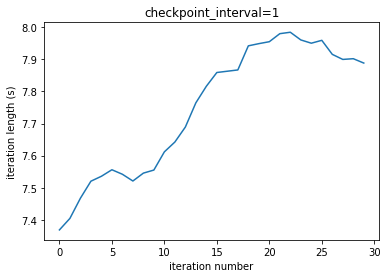

In [37]:
plt.plot(iteration_times)
plt.xlabel('iteration number')
plt.ylabel('iteration length (s)')
plt.title('checkpoint_interval=1')

In [35]:
np.sum(iteration_times)

232.41701793670654

When using checkpoint_interval=1, each iteration takes about 7-8 seconds

## Run 30 iterations with checkpoint interval = 10

In [32]:
# Set up sampler
_logger.setLevel(logging.DEBUG)
_logger.info("About to start repex")
print(f"move steps: {int((move_length*1000)/timestep)}")
print(f"timestep: {timestep} fs")
move = mcmc.LangevinSplittingDynamicsMove(timestep=timestep*unit.femtoseconds, n_steps=int((move_length*1000)/timestep))
simulation2 = ReplicaExchangeSampler2(mcmc_moves=move, number_of_iterations=30)

# Run t-repex
reporter_file = os.path.join(outdir, f"test_chk10.nc")
reporter = multistate.MultiStateReporter(reporter_file, checkpoint_interval=10)
simulation2.create(thermodynamic_states=thermodynamic_state_list,
                  sampler_states=sampler_state_list,
                  storage=reporter)
iteration_times2 = simulation2.run()


INFO:root:About to start repex
DEBUG:openmmtools.multistate.multistatereporter:Initial checkpoint file automatically chosen as /data/chodera/zhangi/perses_benchmark/neq/14/16/test_chk10_checkpoint.nc
DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateReporter.storage_exists of <openmmtools.multistate.multistatereporter.MultiStateReporter object at 0x2b349e41bd30>>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._display_citations at 0x2b343b460310>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._display_citations at 0x2b343b41ac10>
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._initialize_reporter at 0x2b343b41aee0>


move steps: 250
timestep: 4 fs
Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys.,

DEBUG:openmmtools.multistate.multistatereporter:Serialized state thermodynamic_states/0 is  777536B | 759.312KB | 0.742MB
DEBUG:openmmtools.utils:Storing thermodynamic states took    1.468s
DEBUG:openmmtools.multistate.multistatesampler:Storing general ReplicaExchange options...
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x2b343b420040>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler2._report_iteration_items at 0x2b3494141af0>
DEBUG:openmmtools.utils:Storing sampler states took    0.004s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.047s
DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:Computing energy matrix took    0.308s
DEBUG:mpiplus.mpiplus:Single node: executing <bound method MultiStateReporter.write_energies of <openmmtools.multistate.multistatereporter.MultiStateReporter object at 0x2b349e41bd30>>
DEBUG:root:*********************

DEBUG:root:Iteration 4/30
DEBUG:root:********************************************************************************
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._mix_replicas at 0x2b343b468f70>
DEBUG:openmmtools.multistate.replicaexchange:Mixing replicas...
DEBUG:openmmtools.utils:Mixing of replicas took    0.001s
DEBUG:openmmtools.multistate.replicaexchange:Accepted 7522/41472 attempted swaps (18.1%)
DEBUG:openmmtools.multistate.multistatesampler:Propagating all replicas...
DEBUG:mpiplus.mpiplus:Running _propagate_replica serially.
DEBUG:mpiplus.mpiplus:Running _get_replica_move_statistics serially.
DEBUG:openmmtools.utils:Propagating all replicas took    7.345s
DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:Computing energy matrix took    0.235s
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x2b343b420040>
DEBUG:mpiplus.mpiplus:Single node: executing <function

DEBUG:openmmtools.utils:Computing online free energy estimate took    0.005s
DEBUG:root:Iteration took 7.503s.
DEBUG:root:Estimated completion in 0:02:52.338694, at Fri Mar 26 17:36:05 2021 (consuming total wall clock time 0:03:44.789601).
DEBUG:root:********************************************************************************
DEBUG:root:Iteration 8/30
DEBUG:root:********************************************************************************
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._mix_replicas at 0x2b343b468f70>
DEBUG:openmmtools.multistate.replicaexchange:Mixing replicas...
DEBUG:openmmtools.utils:Mixing of replicas took    0.001s
DEBUG:openmmtools.multistate.replicaexchange:Accepted 7438/41472 attempted swaps (17.9%)
DEBUG:openmmtools.multistate.multistatesampler:Propagating all replicas...
DEBUG:mpiplus.mpiplus:Running _propagate_replica serially.
DEBUG:mpiplus.mpiplus:Running _get_replica_move_statistics serially.
DEBUG:openmmtools.utils:P

DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE analysis free energies:
DEBUG:openmmtools.multistate.multistatesampler:        -0.0    25.2    25.2    25.2    25.2    25.2    25.2    25.2    25.2    25.2    25.2    25.2
DEBUG:openmmtools.utils:Computing online free energy estimate took    0.005s
DEBUG:root:Iteration took 7.560s.
DEBUG:root:Estimated completion in 0:02:22.678621, at Fri Mar 26 17:36:05 2021 (consuming total wall clock time 0:03:45.282034).
DEBUG:root:********************************************************************************
DEBUG:root:Iteration 12/30
DEBUG:root:********************************************************************************
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler._mix_replicas at 0x2b343b468f70>
DEBUG:openmmtools.multistate.replicaexchange:Mixing replicas...
DEBUG:openmmtools.utils:Mixing of replicas took    0.001s
DEBUG:openmmtools.multistate.replicaexchange:Accepted 6912/41472 attempted swaps (16.7

DEBUG:openmmtools.utils:Writing iteration information to storage took    0.015s
DEBUG:openmmtools.multistate.multistatesampler:Not enough iterations for online analysis (self.online_analysis_minimum_iterations = 200)
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._online_analysis at 0x2b343b420e50>
DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE analysis free energies:
DEBUG:openmmtools.multistate.multistatesampler:        -0.0    28.6    28.6    28.6    28.6    28.6    28.6    28.6    28.6    28.6    28.6    28.6
DEBUG:openmmtools.utils:Computing online free energy estimate took    0.005s
DEBUG:root:Iteration took 7.697s.
DEBUG:root:Estimated completion in 0:01:53.237638, at Fri Mar 26 17:36:06 2021 (consuming total wall clock time 0:03:46.475277).
DEBUG:root:********************************************************************************
DEBUG:root:Iteration 16/30
DEBUG:root:**************************************************************************

DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler2._report_iteration_items at 0x2b3494141af0>
DEBUG:openmmtools.multistate.multistatereporter:Iteration 19 not on the Checkpoint Interval of 10. Sampler State not written.
DEBUG:openmmtools.utils:Storing sampler states took    0.002s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.014s
DEBUG:openmmtools.multistate.multistatesampler:Not enough iterations for online analysis (self.online_analysis_minimum_iterations = 200)
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._online_analysis at 0x2b343b420e50>
DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE analysis free energies:
DEBUG:openmmtools.multistate.multistatesampler:        -0.0    31.2    31.2    31.2    31.2    31.2    31.2    31.2    31.2    31.2    31.2    31.2
DEBUG:openmmtools.utils:Computing online free energy estimate took    0.005s
DEBUG:root:Iteration took 7.784s.
DEBUG:root:Estimated co

DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:Computing energy matrix took    0.252s
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x2b343b420040>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler2._report_iteration_items at 0x2b3494141af0>
DEBUG:openmmtools.multistate.multistatereporter:Iteration 23 not on the Checkpoint Interval of 10. Sampler State not written.
DEBUG:openmmtools.utils:Storing sampler states took    0.002s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.015s
DEBUG:openmmtools.multistate.multistatesampler:Not enough iterations for online analysis (self.online_analysis_minimum_iterations = 200)
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._online_analysis at 0x2b343b420e50>
DEBUG:openmmtools.multistate.multistatesampler:*** ONLINE analysis free energies:
DEBUG:openmmtools.multistate.multistatesamp

DEBUG:openmmtools.multistate.replicaexchange:Accepted 6846/41472 attempted swaps (16.5%)
DEBUG:openmmtools.multistate.multistatesampler:Propagating all replicas...
DEBUG:mpiplus.mpiplus:Running _propagate_replica serially.
DEBUG:mpiplus.mpiplus:Running _get_replica_move_statistics serially.
DEBUG:openmmtools.utils:Propagating all replicas took    7.921s
DEBUG:mpiplus.mpiplus:Running _compute_replica_energies serially.
DEBUG:openmmtools.utils:Computing energy matrix took    0.265s
DEBUG:mpiplus.mpiplus:Single node: executing <function MultiStateSampler._report_iteration at 0x2b343b420040>
DEBUG:mpiplus.mpiplus:Single node: executing <function ReplicaExchangeSampler2._report_iteration_items at 0x2b3494141af0>
DEBUG:openmmtools.multistate.multistatereporter:Iteration 27 not on the Checkpoint Interval of 10. Sampler State not written.
DEBUG:openmmtools.utils:Storing sampler states took    0.002s
DEBUG:openmmtools.utils:Writing iteration information to storage took    0.015s
DEBUG:openmmtoo

When using checkpoint_interval=1, each iteration takes about 7-8 seconds

Text(0.5, 1.0, 'checkpoint_interval=10')

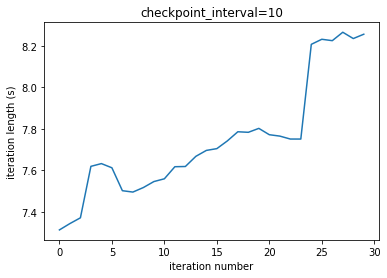

In [38]:
plt.plot(iteration_times2)
plt.xlabel('iteration number')
plt.ylabel('iteration length (s)')
plt.title('checkpoint_interval=10')

In [34]:
np.sum(iteration_times2)

232.4078619480133

In [45]:
with open("/data/chodera/zhangi/perses_benchmark/neq/14/19/14.19.1.stderr", "r") as f:
    lines = f.readlines()

In [61]:
times = []
for line in lines:
    if "Iteration took" in line:
        time = float(line.split(" ")[-1].strip('s.\n'))
        times.append(time)

Text(0.5, 1.0, 'checkpoint_interval=1')

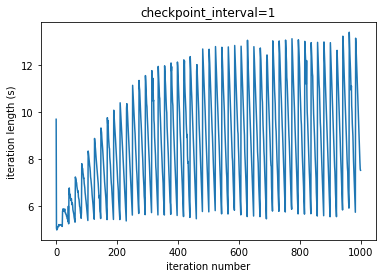

In [64]:
plt.plot(times)
plt.xlabel('iteration number')
plt.ylabel('iteration length (s)')
plt.title('checkpoint_interval=1')

9.811

In [67]:
for i, time in enumerate(times):
    print(i, time)

0 9.695
1 5.046
2 4.97
3 4.988
4 5.019
5 5.071
6 5.103
7 5.135
8 5.116
9 5.198
10 5.154
11 5.177
12 5.172
13 5.183
14 5.196
15 5.193
16 5.178
17 5.16
18 5.155
19 5.17
20 5.119
21 5.772
22 5.823
23 5.874
24 5.797
25 5.775
26 5.779
27 5.764
28 5.864
29 5.736
30 5.694
31 5.7
32 5.637
33 5.631
34 5.561
35 5.525
36 5.516
37 5.429
38 5.513
39 5.318
40 5.982
41 5.231
42 6.566
43 6.762
44 6.456
45 6.499
46 6.469
47 6.313
48 6.285
49 6.225
50 6.302
51 6.131
52 6.048
53 6.117
54 6.02
55 5.823
56 5.76
57 5.681
58 5.639
59 5.515
60 5.443
61 5.365
62 5.301
63 7.231
64 7.161
65 7.149
66 7.014
67 6.985
68 6.833
69 6.751
70 6.678
71 6.58
72 6.634
73 6.387
74 6.313
75 6.272
76 6.122
77 5.975
78 5.941
79 5.806
80 5.668
81 5.641
82 5.468
83 5.729
84 7.8
85 7.703
86 7.608
87 7.587
88 7.407
89 7.329
90 7.17
91 7.184
92 6.964
93 6.857
94 6.764
95 6.554
96 6.448
97 6.299
98 6.208
99 6.066
100 5.921
101 5.756
102 5.612
103 5.492
104 5.372
105 8.338
106 8.247
107 8.111
108 8.004
109 7.816
110 7.711
111 7.62
11

(array([104., 148., 131., 118., 106., 106.,  84.,  83.,  82.,  38.]),
 array([ 4.97  ,  5.8142,  6.6584,  7.5026,  8.3468,  9.191 , 10.0352,
        10.8794, 11.7236, 12.5678, 13.412 ]),
 <BarContainer object of 10 artists>)

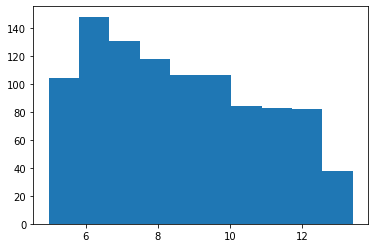

In [68]:
plt.hist(times)

In [69]:
count = 0
for time in times:
    if time > 8:
        count += 1
print(count)

550


In [5]:
from simtk.openmm import XmlSerializer


In [2]:
# Load rhtf 
outdir = '/data/chodera/zhangi/perses_benchmark/neq/14/16/'
resid = '439'
old_aa_name = 'ASN'
new_aa_nname = 'LYS'
path = os.path.join(outdir, f"16_apo_0.pickle")
htf = pickle.load(open(path, "rb" ))

In [4]:
with open(os.path.join(outdir, "16_apo_0_hybrid_system.xml"), 'w') as f:
    f.write(XmlSerializer.serialize(htf.hybrid_system))


In [6]:
with open(os.path.join(outdir, "16_apo_0_hybrid_topology.pickle"), 'wb') as f:
    pickle.dump(htf.hybrid_topology, f)


In [7]:
with open(os.path.join(outdir, "16_apo_0_hybrid_positions.pickle"), 'wb') as f:
    pickle.dump(htf.hybrid_positions, f)


In [3]:
# Load vanilla htf 
outdir = '/data/chodera/zhangi/perses_benchmark/neq/14/16/'
resid = '439'
old_aa_name = 'ASN'
new_aa_nname = 'LYS'
path = os.path.join(outdir, f"16_apo.pickle")
htf = pickle.load(open(path, "rb" ))

In [6]:
with open(os.path.join(outdir, "16_apo_hybrid_system.xml"), 'w') as f:
    f.write(XmlSerializer.serialize(htf.hybrid_system))


In [7]:
with open(os.path.join(outdir, "16_apo_hybrid_topology.pickle"), 'wb') as f:
    pickle.dump(htf.hybrid_topology, f)


In [8]:
with open(os.path.join(outdir, "16_apo_hybrid_positions.pickle"), 'wb') as f:
    pickle.dump(htf.hybrid_positions, f)
